In [46]:
import pandas as pd
import math
import random
import time

# Preprocesamiento de información

## Demandas por Poligono

In [47]:
# 1. Cargar y limpiar como en el original
df_raw = pd.read_excel("Tabla Reto Completo.xlsx", sheet_name="Poligono")

# Eliminar filas basura iniciales
df_raw = df_raw.drop([1, 2])

# Tomar solo 32 filas y 12 columnas (polígono + 10 especies + total)
df_raw = df_raw.iloc[:32, :12]

# Eliminar segunda columna de polígonos (duplicada)
df_raw = df_raw.drop(columns=df_raw.columns[1])

# Reiniciar índice para limpieza
df_raw = df_raw.reset_index(drop=True)

# 2. Reasignar encabezados desde la primera fila original
df_shifted = df_raw.shift(-1)
df_shifted.columns = df_raw.iloc[0].tolist()
df_shifted = df_shifted.dropna().reset_index(drop=True)

# 3. Renombrar columna principal
df_shifted.rename(columns={df_shifted.columns[0]: "Poligonos"}, inplace=True)

# 4. Convertir a numérico y establecer índice
df_shifted.iloc[:, 1:] = df_shifted.iloc[:, 1:].apply(pd.to_numeric)
df_shifted["Poligonos"] = df_shifted["Poligonos"].astype(str)

# LIMPIA LOS NOMBRES DE LAS COLUMNAS (especies)
df_shifted.columns = df_shifted.columns.str.strip()

df_demandas = df_shifted.set_index("Poligonos")

# 5. Eliminar duplicados por seguridad
df_demandas = df_demandas[~df_demandas.index.duplicated(keep="first")]

# 6. Ordenar: primero '18', luego el resto en orden numérico
fila_18 = df_demandas.loc[["18"]]
resto = df_demandas.drop("18", axis=0)
resto = resto.loc[sorted(resto.index, key=lambda x: int(x))]
df_demandas = pd.concat([fila_18, resto])

# 7. Crear demandas_tipo_planta y redondear como en el original
demandas_tipo_planta = df_demandas.values.tolist()
for i in range(len(demandas_tipo_planta)):
    for j in range(len(demandas_tipo_planta[i])):
        demandas_tipo_planta[i][j] = math.ceil(demandas_tipo_planta[i][j])

# 8. Crear diccionario con claves de polígonos
dictionary_demands_tipo_planta = dict(zip(df_demandas.index.tolist(), demandas_tipo_planta))

# 9. Validar orden
print("Polígonos en orden:", df_demandas.index.tolist())
print("Demanda de '18':", dictionary_demands_tipo_planta['18'])


Polígonos en orden: ['18', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
Demanda de '18': [235, 1117, 235, 235, 278, 214, 413, 363, 491, 150]


## Matriz de Tiempos

In [48]:
# 1. Cargar matriz completa
df_distancias = pd.read_excel("Time_matrix Completo.xlsx")

# 2. Renombrar columna para claridad
df_distancias = df_distancias.rename(columns={"Unnamed: 0": "Poligono"})

# 3. Convertir la columna de polígonos en índice
df_distancias["Poligono"] = df_distancias["Poligono"].astype(str)
df_distancias = df_distancias.set_index("Poligono")

# 4. Asegurar que columnas sean string
df_distancias.columns = df_distancias.columns.astype(str)
df_distancias.index = df_distancias.index.astype(str)

# 5. Asegurar cuadrada y simétrica
assert df_distancias.shape[0] == df_distancias.shape[1], "La matriz no es cuadrada"
assert set(df_distancias.columns) == set(df_distancias.index), "Columnas ≠ Filas"

# 6. Ordenar: '18' primero, resto en orden numérico
resto = sorted([i for i in df_distancias.index if i != '18'], key=int)
orden_final = ['18'] + resto
df_distancias = df_distancias.loc[orden_final, orden_final]

# 7. Validar
print("Dimensión:", df_distancias.shape)
print("Primeros polígonos:", df_distancias.index.tolist()[:5])


Dimensión: (31, 31)
Primeros polígonos: ['18', '1', '2', '3', '4']


In [49]:
# 1. cluster_all: todos los polígonos en el orden de df_distancias
cluster_all = df_distancias.index.tolist()

# 2. demands_all: lista total de demanda por polígono
import math
total_demandas = df_demandas.sum(axis=1).apply(math.ceil).to_dict()
demands_all = [total_demandas[p] for p in cluster_all]

# 3. matriz completa como lista de listas
df_matriz_all_list = df_distancias.values.tolist()


# VRP

## Generalizado por cantidad plantas

In [50]:
class Node:
    def __init__(self, id, index, demand):
        self.id = id
        self.index = index
        self.demand = demand

    def display_info(self):
        print(f"ID: {self.id}, Demand: {self.demand}")

class Worker:
    def __init__(self, capacity):
        self.capacity = capacity
        self.load = 0

    def load_cargo(self):
        self.load = self.capacity

    def unload(self, node):
        if self.load >= node.demand:
            self.load -= node.demand
            node.demand = 0
        else:
            node.demand -= self.load
            self.load = 0

    def find_solution(self, distance_matrix, cluster0, demands_cluster0):
        accumulated_cost = 0
        depot_id = cluster0[0]
        Node_Group = [Node(cluster0[i], i, demands_cluster0[i]) 
                    for i in range(len(cluster0)) if cluster0[i] != depot_id]

        group_members = [node.id for node in Node_Group]
        all_routes = []
        while Node_Group:
            self.load_cargo()
            accumulated_cost += 0.5  # Cost to start from depot
            initial_position = 0
            route = [cluster0[0]]  # Polígono 18 como ID real

            while self.load > 0 and Node_Group:
                depot_id = cluster0[0]
                unserved_indices = [node.index for node in Node_Group]
                distances = distance_matrix[initial_position]
                node_index_go = min(unserved_indices, key=lambda idx: distances[idx])
                cost_to_next = distances[node_index_go]

                accumulated_cost += cost_to_next

                for node in Node_Group[:]:
                    if node.index == node_index_go:
                        self.unload(node)
                        route.append(node.id)
                        if node.demand == 0:
                            Node_Group.remove(node)
                        break
                initial_position = node_index_go

            # Solo suma el regreso si la ruta visitó algún nodo distinto a 18
            if any(n != cluster0[0] for n in route[1:]):
                cost_return = distance_matrix[initial_position][0]
                accumulated_cost += cost_return  # Regreso al depósito

            accumulated_cost += 0.5  # 0.5h de descarga SIEMPRE

            route.append(cluster0[0])  # Regresa al polígono 18 (ID real)
            all_routes.append(route)

        print("\n🟢  FINAL")
        print("📋 Miembros del grupo:", group_members)
        print(f"⏱️  Tiempo total acumulado: {round(accumulated_cost, 2)} horas")
        print(f"🚚 Número de rutas: {len(all_routes)}")
        for i, r in enumerate(all_routes):
            print(f"🛣️  Ruta {i+1}: {r}")

        return all_routes, accumulated_cost

    def display_info_specifics(self):
        pass

    def display_info(self):
        print(f"Load: {self.load}")

# 4. Ejecutar
worker = Worker(capacity=524)
solution_all = worker.find_solution(df_matriz_all_list, cluster_all, demands_all)


🟢  FINAL
📋 Miembros del grupo: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
⏱️  Tiempo total acumulado: 192.65 horas
🚚 Número de rutas: 183
🛣️  Ruta 1: ['18', '24', '18']
🛣️  Ruta 2: ['18', '24', '18']
🛣️  Ruta 3: ['18', '24', '18']
🛣️  Ruta 4: ['18', '24', '18']
🛣️  Ruta 5: ['18', '24', '18']
🛣️  Ruta 6: ['18', '24', '23', '18']
🛣️  Ruta 7: ['18', '17', '18']
🛣️  Ruta 8: ['18', '17', '18']
🛣️  Ruta 9: ['18', '17', '18']
🛣️  Ruta 10: ['18', '17', '18']
🛣️  Ruta 11: ['18', '17', '18']
🛣️  Ruta 12: ['18', '17', '18']
🛣️  Ruta 13: ['18', '17', '16', '18']
🛣️  Ruta 14: ['18', '13', '18']
🛣️  Ruta 15: ['18', '13', '18']
🛣️  Ruta 16: ['18', '13', '18']
🛣️  Ruta 17: ['18', '13', '18']
🛣️  Ruta 18: ['18', '13', '18']
🛣️  Ruta 19: ['18', '13', '14', '18']
🛣️  Ruta 20: ['18', '23', '18']
🛣️  Ruta 21: ['18', '23', '18']
🛣️  Ruta 22: ['18', '23', '18']
🛣️  Ruta 23: ['18',

# Clases

## Funcion Objetivo

In [51]:
class Funcion_Objetivo:
    def __init__(self,dias_proyecto):
        self.dias_proyecto = dias_proyecto
        self.adquisicion_plantas = 0
        self.transporte_abastecimiento = 0
        self.plantacion = 0
        self.transporte_interno = 0

    def porcentaje_contribucion(self,costo,costo_total):
        try:
            if costo != 0 :
                return str(round(100*costo/costo_total,1))
            else:
                return "0.00"
        except ZeroDivisionError:
            return "0.00"

    def display(self):
        costo_total = sum([self.adquisicion_plantas,self.transporte_abastecimiento,self.plantacion,self.transporte_interno])
        print("Resumen de costos para duración de proyecto de ",self.dias_proyecto,"dias")
        print("──────────────────────────────────────────")
        print('Costo total:',f'{costo_total:,}')
        print('--Costo por partes--')
        print('(%'+self.porcentaje_contribucion(self.adquisicion_plantas,costo_total)+')Costo adquisicion plantas:',f'{self.adquisicion_plantas:,}',"pesos")
        print('(%'+self.porcentaje_contribucion(self.transporte_abastecimiento,costo_total)+')Costo transporte de abastecimiento:',f'{self.transporte_abastecimiento:,}',"pesos")
        print('(%'+self.porcentaje_contribucion(self.plantacion,costo_total)+')Costo de plantacion: ',f'{self.plantacion:,}',"pesos")
        print('(%'+self.porcentaje_contribucion(self.transporte_interno,costo_total)+')Costo transporte interno: ', f'{self.transporte_interno:,.2f}',"horas en cargar, descargar y transportar plantas a poligonos, asumiendo velocidad constante de 30km/h.")

## Simulación Heurístico Genetico para pedido óptimo

In [52]:
PLANT_AREA = {
    "Agave lechuguilla": 0.07068583470577035,
    "Agave salmiana": 0.07068583470577035,
    "Agave scabra": 0.025446900494077326,
    "Agave striata": 0.037154241867220536,
    "Opuntia cantabrigiensis": 0.037154241867220536,
    "Opuntia engelmani": 0.03463605900582747,
    "Opuntia robusta": 0.039760782021995816,
    "Opuntia streptacanta": 0.037154241867220536,
    "Prosopis laevigata": 0.051070515574919075,
    "Yucca filifera": 0.03463605900582747
}

PROVIDERS = {
    "Moctezuma": {
        "Agave scabra": 26,
        "Agave striata": 26,
        "Opuntia cantabrigiensis": 17,
        "Prosopis laevigata": 26.5,
        "Yucca filifera": 26
    },
    "Venado": {
        "Agave striata": 25,
        "Opuntia cantabrigiensis": 18,
        "Opuntia engelmannii": 18,
        "Opuntia robusta": 17,
        "Opuntia streptacanta": 18
    },
    "Laguna Seca": {
        "Agave lechuguilla": 26,
        "Agave salmiana": 26,
        "Agave scabra": 26,
        "Opuntia engelmannii": 21,
        "Opuntia robusta": 18
    }
}

Proporciones_por_planta = {
    "Agave lechuguilla": 6.2977,
    "Agave salmiana": 29.9618,
    "Agave scabra": 6.2977,
    "Agave striata": 6.2977,
    "Opuntia cantabrigiensis": 7.4427,
    "Opuntia engelmani": 5.7252,
    "Opuntia robusta": 5.7252,
    "Opuntia streptacanta": 9.7328,
    "Prosopis laevigata": 13.1679,
    "Yucca filifera": 4.0076
}

MAX_PLANTS_PER_DAY = 8000
STORAGE_CAPACITY = 400

resultados = []
gasto_acumulado = 0

In [53]:
#Encontrar el mejor pedido con greedy

plantas_tipo = ['Agave lechuguilla',
 'Agave salmiana',
 'Agave scabra',
 'Agave striata',
 'Opuntia cantabrigiensis',
 'Opuntia engelmani',
 'Opuntia robusta',
 'Opuntia streptacanta',
 'Prosopis laevigata',
 'Yucca filifera']
min_pedido_por_planta_y_proveedor = {}
#Pedido más barato
for planta in plantas_tipo:
  min_val = 100000
  for provider in PROVIDERS:
    try:
      if PROVIDERS[provider][planta] < min_val:
        min_val = PROVIDERS[provider][planta]
        min_pedido_por_planta_y_proveedor[planta] = [provider,min_val]
    except KeyError:
      continue
min_pedido_por_planta_y_proveedor#Planta:el proveedor que la venda mas barato y el precio de la planta

{'Agave lechuguilla': ['Laguna Seca', 26],
 'Agave salmiana': ['Laguna Seca', 26],
 'Agave scabra': ['Moctezuma', 26],
 'Agave striata': ['Venado', 25],
 'Opuntia cantabrigiensis': ['Moctezuma', 17],
 'Opuntia robusta': ['Venado', 17],
 'Opuntia streptacanta': ['Venado', 18],
 'Prosopis laevigata': ['Moctezuma', 26.5],
 'Yucca filifera': ['Moctezuma', 26]}

In [54]:
hectareas = {
    'Agave lechuguilla': 33,
    'Agave salmiana': 157,
    'Agave scabra': 33,
    'Agave striata': 33,
    'Opuntia cantabrigiensis': 39,
    'Opuntia engelmani': 30,
    'Opuntia robusta': 58,
    'Opuntia streptacanta': 51,
    'Prosopis laevigata': 69,
    'Yucca filifera': 21
}
minimo_diario = {key: value*5 for key,value in hectareas.items()}
minimo_diario

{'Agave lechuguilla': 165,
 'Agave salmiana': 785,
 'Agave scabra': 165,
 'Agave striata': 165,
 'Opuntia cantabrigiensis': 195,
 'Opuntia engelmani': 150,
 'Opuntia robusta': 290,
 'Opuntia streptacanta': 255,
 'Prosopis laevigata': 345,
 'Yucca filifera': 105}

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      1 |  4.996286E+01 |  7.146985E+02 |             - |             -
     2 |      400 |      1 |  1.403652E+01 |  4.529463E+02 |             - |             -
     3 |      600 |      1 |  1.403652E+01 |  3.036751E+02 |             - |             -
     4 |      800 |      1 |  0.000000E+00 |  2.044363E+02 |             - |             -
     5 |     1000 |      3 |  0.000000E+00 |  1.201394E+02 |  1.0000000000 |         ideal
     6 |     1200 |      9 |  0.000000E+00 |  5.438066E+01 |  0.3924084401 |         ideal
     7 |     1400 |     16 |  0.000000E+00 |  1.612928E+01 |  0.0501540542 |         ideal
     8 |     1600 |     19 |  0.000000E+00 |  4.1127413534 |  0.1225653771 |         ideal
     9 |     1800 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0281799246 |             f
    10 |     2000 |     36 |  0.000000E+00 |  0.000000E+00 |  0.1191700316 |         ideal

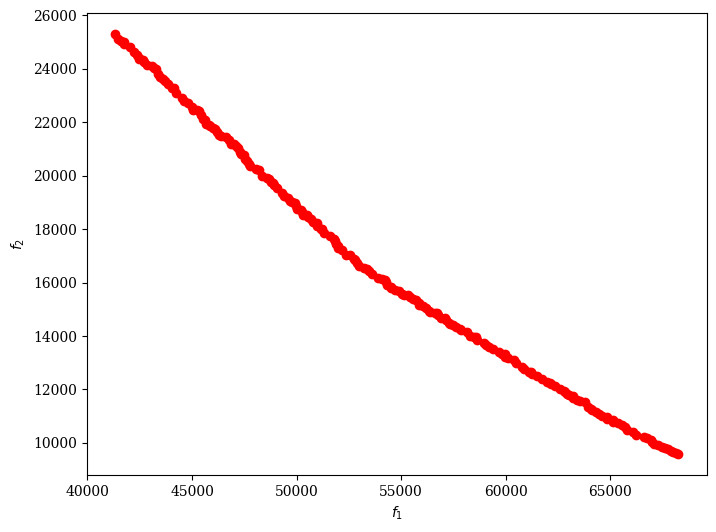

In [55]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# Parámetros del problema
PLANT_AREA = {
    "Agave lechuguilla": 0.07068583470577035,
    "Agave salmiana": 0.07068583470577035,
    "Agave scabra": 0.025446900494077326,
    "Agave striata": 0.037154241867220536,
    "Opuntia cantabrigiensis": 0.037154241867220536,
    "Opuntia engelmani": 0.03463605900582747,
    "Opuntia robusta": 0.039760782021995816,
    "Opuntia streptacanta": 0.037154241867220536,
    "Prosopis laevigata": 0.051070515574919075,
    "Yucca filifera": 0.03463605900582747
}

PROVIDERS = {
    "Moctezuma": {
        "Agave scabra": 26,
        "Agave striata": 26,
        "Opuntia cantabrigiensis": 17,
        "Prosopis laevigata": 26.5,
        "Yucca filifera": 26
    },
    "Venado": {
        "Agave striata": 25,
        "Opuntia cantabrigiensis": 18,
        "Opuntia engelmani": 18,
        "Opuntia robusta": 17,
        "Opuntia streptacanta": 18
    },
    "Laguna Seca": {
        "Agave lechuguilla": 26,
        "Agave salmiana": 26,
        "Agave scabra": 26,
        "Opuntia engelmani": 21,
        "Opuntia robusta": 18
    }
}

Proporciones_por_planta = {
    "Agave lechuguilla": 6.2977,
    "Agave salmiana": 29.9618,
    "Agave scabra": 6.2977,
    "Agave striata": 6.2977,
    "Opuntia cantabrigiensis": 7.4427,
    "Opuntia engelmani": 5.7252,
    "Opuntia robusta": 5.7252,
    "Opuntia streptacanta": 9.7328,
    "Prosopis laevigata": 13.1679,
    "Yucca filifera": 4.0076
}

# Normalización de proporciones
total_prop = sum(Proporciones_por_planta.values())
P = {k: v / total_prop for k, v in Proporciones_por_planta.items()}

# Mínimo diario requerido
hectareas = {
    'Agave lechuguilla': 33,
    'Agave salmiana': 157,
    'Agave scabra': 33,
    'Agave striata': 33,
    'Opuntia cantabrigiensis': 39,
    'Opuntia engelmani': 30,
    'Opuntia robusta': 58,
    'Opuntia streptacanta': 51,
    'Prosopis laevigata': 69,
    'Yucca filifera': 21
}
minimo_diario = {k: v * 5 for k, v in hectareas.items()}

plants = list(PLANT_AREA.keys())
providers = list(PROVIDERS.keys())
idx = [(p, pr) for pr in providers for p in PROVIDERS[pr]]

class PlantOptimizationProblem(ElementwiseProblem):

    def __init__(self):
        # Número de variables: cantidad de plantas por proveedor y especie
        n_var = len(idx)
        # Dos objetivos: costo total y penalización por desviación de proporciones
        n_obj = 2
        # Sin restricciones de igualdad, solo de desigualdad
        n_ieq_constr = len(plants) + 2
        # Límites inferiores y superiores para las variables
        xl = np.zeros(n_var)
        xu = np.full(n_var, 300)
        super().__init__(n_var=n_var, n_obj=n_obj, n_ieq_constr=n_ieq_constr, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        total_cost = 0
        total_area = 0
        total_plants = 0
        count_by_plant = {p: 0 for p in plants}
        count_by_provider = {pr: 0 for pr in providers}

        for (amount, (p, pr)) in zip(x, idx):
            if p not in PROVIDERS[pr]:
                amount = 0
            cost = PROVIDERS[pr][p] * amount
            area = PLANT_AREA[p] * amount
            total_cost += cost
            total_area += area
            total_plants += amount
            count_by_plant[p] += amount
            count_by_provider[pr] += amount

        # Penalización por exceder capacidad de espacio
        penalty = 0
        if total_area > 400 / 3:
            penalty += 10000 * (total_area - 400 / 3)

        # Penalización por exceder cantidad total de plantas
        if total_plants > 8000:
            penalty += 10000 * (total_plants - 8000)

        # Penalización por desviación de proporciones ideales
        if total_plants > 0:
            for p in plants:
                actual = count_by_plant[p]
                expected = P[p] * total_plants
                penalty += abs(actual - expected) * 5

                # Penalización por no cumplir mínimo diario (ajustada proporcionalmente)
                if actual < minimo_diario[p]:
                    # Definimos una penalización proporcional basada en el déficit
                    deficit = minimo_diario[p] - actual
                    penalty += deficit * 10  # Ajusta el multiplicador si es necesario

        else:
            penalty += 100000

        # Penalización por número de proveedores utilizados
        y_cost = 4500 * sum(1 for c in count_by_provider.values() if c > 0)

        # Los objetivos ahora están ajustados, la penalización es proporcional al déficit
        out["F"] = [total_cost + y_cost + penalty, penalty]

        # Restricciones: espacio total y cantidad total de plantas
        out["G"] = np.array([total_area - 400 / 3, total_plants - 8000] +
                            [count_by_plant[p] - minimo_diario[p] for p in plants])

import time

# Medir el tiempo de ejecución de la optimización
start = time.perf_counter()

# Inicialización del problema
problem = PlantOptimizationProblem()

# Configuración del algoritmo NSGA-II
algorithm = NSGA2(pop_size=200)

# Ejecución de la optimización
res = minimize(problem,
               algorithm,
               ('n_gen', 300),
               seed=42,
               verbose=True)

end = time.perf_counter()
tiempo_optimizacion = end - start
print(f"⏱️ Tiempo total de optimización: {round(end - start, 2)} segundos")

# Visualización de los resultados (Frente de Pareto)
plot = Scatter()
plot.add(res.F, color="red")
plot.show()
# esto ponlo|

In [56]:
# Obtener el índice de la solución con el menor costo total
best_index_cost = np.argmin(res.F[:, 0])

# Obtener el valor de la mejor solución para la primera función objetivo (costo total)
best_cost = res.F[best_index_cost, 0]

# Obtener la solución de decisión correspondiente a esta función objetivo
best_solution = res.X[best_index_cost]

print("Mejor solución basada en el costo total:")
print("Costo total:", best_cost)
print("Solución (cantidad de plantas por proveedor y especie):", best_solution)
#Se descarta porque no tiene en este caso reducir tanto los costos y pedir tan poco de las plantas


Mejor solución basada en el costo total:
Costo total: 41312.8649536985
Solución (cantidad de plantas por proveedor y especie): [ 2.76845572  0.16035332  0.59610814  7.44812121  0.38367403  0.43679008
 13.51327027  0.41284932  5.31737027 16.14728071  6.60952045 40.33035308
  6.75584728  6.65112454  2.54156781]


In [57]:
#Visualizar mejor solucion y datos
best_index = np.argmin(res.F[:, 1])  # o alguna función compuesta
best_solution = res.X[best_index]
print("Resumen de Resultados: Mejor solucion menor penalizada:")
print("------------------------")
for (amount, (plant, provider)) in zip(best_solution, idx):print(f"{plant} - {provider}: {int(amount)}")
# esto ponlo
proveedores_usados = set()

for (amount, (plant, provider)) in zip(best_solution, idx):
    if amount > 0:
        proveedores_usados.add(provider)

print(f"\nProveedores únicos utilizados: {len(proveedores_usados)}")
print("Listado:", proveedores_usados)


Resumen de Resultados: Mejor solucion menor penalizada:
------------------------
Agave scabra - Moctezuma: 69
Agave striata - Moctezuma: 73
Opuntia cantabrigiensis - Moctezuma: 64
Prosopis laevigata - Moctezuma: 299
Yucca filifera - Moctezuma: 96
Agave striata - Venado: 74
Opuntia cantabrigiensis - Venado: 129
Opuntia engelmani - Venado: 60
Opuntia robusta - Venado: 131
Opuntia streptacanta - Venado: 228
Agave lechuguilla - Laguna Seca: 154
Agave salmiana - Laguna Seca: 299
Agave scabra - Laguna Seca: 75
Opuntia engelmani - Laguna Seca: 83
Opuntia robusta - Laguna Seca: 153

Proveedores únicos utilizados: 3
Listado: {'Moctezuma', 'Laguna Seca', 'Venado'}


In [58]:
# Obtener el índice de la solución con la menor penalización
best_index_penalty = np.argmin(res.F[:, 1])

# Obtener el valor de la mejor solución para la penalización
best_penalty = res.F[best_index_penalty, 1]

# Obtener la solución de decisión correspondiente a esta función objetivo
best_solution_penalty = res.X[best_index_penalty]

print("Mejor solución basada en penalización:")
print("Penalización total:", best_penalty)
print("Solución (cantidad de plantas por proveedor y especie):", best_solution_penalty)
# esto ponlo

Mejor solución basada en penalización:
Penalización total: 9569.818832694917
Solución (cantidad de plantas por proveedor y especie): [ 69.37669188  73.02970473  64.9216437  299.64641557  96.25277686
  74.87398924 129.58029344  60.80080276 131.70552538 228.98215264
 154.03989907 299.32097148  75.62982868  83.31954872 153.78250757]


In [59]:
# prompt: ssum the number of plantas from the solution above

import numpy as np

# Assuming 'res' and 'idx' are defined from the previous code
best_index = np.argmin(res.F[:, 1])  # Index of the solution with the lowest penalty
best_solution = res.X[best_index]

total_plants = 0
for amount in best_solution:
    total_plants += amount

print(f"Total number of plants in the best solution: {int(total_plants)}")


Total number of plants in the best solution: 1995


In [60]:

total_cost = 0
for (amount, (plant, provider)) in zip(best_solution, idx):
    if plant in PROVIDERS[provider]:
        total_cost += amount * PROVIDERS[provider][plant]

print(f"Total cost of the best solution: {total_cost}")


Total cost of the best solution: 45180.37244628941


In [61]:
# prompt: Espacio total de la solucion usando PLANT_AREA para obtenerlo

# Calculate total area based on the best solution
total_area = 0
for (amount, (plant, provider)) in zip(best_solution, idx):
    if plant in PROVIDERS[provider]:
        total_area += amount * PLANT_AREA[plant]

print(f"Total area occupied by plants in the best solution: {total_area}")


Total area occupied by plants in the best solution: 91.94554021207782


# Simulación por Grupo

In [62]:
# === PARÁMETROS GENERALES ===
  # Plantas que se pueden colocar por día
costo_por_planta = 20
costo_por_pedido_proveedor = 4500

# === CÁLCULO TOTAL DE PLANTAS Y DÍAS NECESARIOS ===
plantas_totales = df_demandas.sum().sum()
plantas_ya_plantadas = 0
plantas_faltantes = plantas_totales - plantas_ya_plantadas
dias = math.ceil(plantas_faltantes / total_plants)

In [63]:
def generar_clusters(cluster_all, tamanos, n_clusters=5, semilla=42):
    random.seed(semilla)
    poligonos_sin_18 = [p for p in cluster_all if p != '18']
    resultados = {}
    for tam in tamanos:
        grupos = []
        for _ in range(n_clusters):
            seleccion = random.sample(poligonos_sin_18, tam-1)
            grupo = ['18'] + seleccion
            grupos.append(grupo)
        resultados[tam] = grupos
    return resultados

# --- Parámetros ---
tamanos = [15, 20, 25]
clusters_dict = generar_clusters(cluster_all, tamanos, n_clusters=5)


## Resultados por Grupo

In [64]:
tabla_resultados = []

for tam in tamanos:
    for grupo in clusters_dict[tam]:
        demands_grupo = [total_demandas[p] for p in grupo]
        indices_grupo = [cluster_all.index(p) for p in grupo]
        matriz_grupo = [[df_matriz_all_list[i][j] for j in indices_grupo] for i in indices_grupo]

        worker = Worker(capacity=524)
        start = time.perf_counter()
        rutas, tiempo_ruteo = worker.find_solution(matriz_grupo, grupo, demands_grupo)
        end = time.perf_counter()
        tiempo_procesamiento = round(end - start + tiempo_optimizacion, 4)

        plantas_totales = sum(demands_grupo)
        dias = math.ceil(plantas_totales / total_plants)  # <--- CORREGIDO

        # ...resto del código igual...
        costo_por_planta = 20
        costo_por_pedido_proveedor = 4500

        costo_adquisicion = 0
        proveedores_usados = set()
        for pol in grupo:
            if pol == '18':
                continue
            demanda = total_demandas[pol]
            for especie in min_pedido_por_planta_y_proveedor:
                proveedor, precio = min_pedido_por_planta_y_proveedor[especie]
                costo_adquisicion += demanda * precio
                proveedores_usados.add(proveedor)
                break

        costo_abastecimiento = len(proveedores_usados) * dias * costo_por_pedido_proveedor

        fo = Funcion_Objetivo(dias)
        fo.adquisicion_plantas = costo_adquisicion
        fo.transporte_abastecimiento = costo_abastecimiento
        fo.plantacion = costo_por_planta * plantas_totales
        fo.transporte_interno = tiempo_ruteo

        costo_total = sum([
            fo.adquisicion_plantas,
            fo.transporte_abastecimiento,
            fo.plantacion,
            fo.transporte_interno
        ])

        tabla_resultados.append({
            "Tamaño clúster": tam,
            "Número de polígonos": len(grupo),
            "Polígonos": ', '.join(grupo),
            "Número de rutas": len(rutas),
            "Días": dias,  # Puedes agregar esta columna si quieres
            "Costo total función objetivo": costo_total,
            "Tiempo de procesamiento (s)": tiempo_procesamiento
        })

# ...existing code...
demands_all = [total_demandas[p] for p in cluster_all]
matriz_all = df_matriz_all_list
worker = Worker(capacity=524)
start = time.perf_counter()
rutas, tiempo_ruteo = worker.find_solution(matriz_all, cluster_all, demands_all)
end = time.perf_counter()
tiempo_procesamiento = round(end - start + tiempo_optimizacion, 4)

plantas_totales = sum(demands_all)
dias = math.ceil(plantas_totales / total_plants)  # <--- CORREGIDO

# Cálculo real de costos para el total
costo_por_planta = 20
costo_por_pedido_proveedor = 4500
costo_adquisicion = 0
proveedores_usados = set()
for pol in cluster_all:
    if pol == '18':
        continue
    demanda = total_demandas[pol]
    for especie in min_pedido_por_planta_y_proveedor:
        proveedor, precio = min_pedido_por_planta_y_proveedor[especie]
        costo_adquisicion += demanda * precio
        proveedores_usados.add(proveedor)
        break

costo_abastecimiento = len(proveedores_usados) * dias * costo_por_pedido_proveedor

fo = Funcion_Objetivo(dias)
fo.adquisicion_plantas = costo_adquisicion
fo.transporte_abastecimiento = costo_abastecimiento
fo.plantacion = costo_por_planta * plantas_totales
fo.transporte_interno = tiempo_ruteo

# Usa sum() como en tu display()
costo_total = sum([
    fo.adquisicion_plantas,
    fo.transporte_abastecimiento,
    fo.plantacion,
    fo.transporte_interno
])

tabla_resultados.append({
    "Tamaño clúster": "ALL",
    "Número de polígonos": len(cluster_all),
    "Polígonos": ', '.join(cluster_all),
    "Número de rutas": len(rutas),
    "Días": dias,  # <--- Añadido para la tabla
    "Costo total función objetivo": costo_total,
    "Tiempo de procesamiento (s)": tiempo_procesamiento
})

fo.display()
df_resultados = pd.DataFrame(tabla_resultados)
df_resultados


🟢  FINAL
📋 Miembros del grupo: ['22', '4', '1', '25', '9', '8', '26', '5', '30', '19', '3', '20', '14', '2']
⏱️  Tiempo total acumulado: 94.49 horas
🚚 Número de rutas: 89
🛣️  Ruta 1: ['18', '14', '18']
🛣️  Ruta 2: ['18', '14', '18']
🛣️  Ruta 3: ['18', '14', '18']
🛣️  Ruta 4: ['18', '14', '18']
🛣️  Ruta 5: ['18', '14', '18']
🛣️  Ruta 6: ['18', '14', '9', '18']
🛣️  Ruta 7: ['18', '30', '18']
🛣️  Ruta 8: ['18', '30', '18']
🛣️  Ruta 9: ['18', '30', '18']
🛣️  Ruta 10: ['18', '30', '18']
🛣️  Ruta 11: ['18', '30', '18']
🛣️  Ruta 12: ['18', '30', '18']
🛣️  Ruta 13: ['18', '30', '22', '18']
🛣️  Ruta 14: ['18', '22', '18']
🛣️  Ruta 15: ['18', '22', '18']
🛣️  Ruta 16: ['18', '22', '18']
🛣️  Ruta 17: ['18', '22', '18']
🛣️  Ruta 18: ['18', '22', '18']
🛣️  Ruta 19: ['18', '22', '18']
🛣️  Ruta 20: ['18', '22', '18']
🛣️  Ruta 21: ['18', '22', '20', '18']
🛣️  Ruta 22: ['18', '19', '18']
🛣️  Ruta 23: ['18', '19', '18']
🛣️  Ruta 24: ['18', '19', '18']
🛣️  Ruta 25: ['18', '19', '18']
🛣️  Ruta 26: ['18', 

,Tamaño clúster,Número de polígonos,Polígonos,Número de rutas,Días,Costo total función objetivo,Tiempo de procesamiento (s)
0,15,15,"18, 22, 4, 1, 25, 9, 8, 26, 5, 30, 19, 3, 20, ...",89,26,2.330890e+06,7.8626
1,15,15,"18, 1, 3, 7, 8, 17, 21, 31, 19, 29, 22, 24, 14...",95,27,2.467968e+06,7.8623
2,15,15,"18, 20, 9, 27, 1, 26, 6, 24, 14, 11, 30, 5, 7,...",79,23,2.068612e+06,7.8622
3,15,15,"18, 3, 13, 4, 12, 28, 21, 9, 2, 15, 19, 29, 30...",95,27,2.475650e+06,7.8622
4,15,15,"18, 28, 22, 21, 12, 20, 7, 24, 3, 2, 8, 10, 25...",89,26,2.316906e+06,7.8622
5,20,20,"18, 13, 9, 15, 22, 12, 6, 27, 25, 7, 30, 3, 26...",108,31,2.796344e+06,7.8625
6,20,20,"18, 24, 19, 8, 23, 11, 26, 2, 29, 25, 27, 13, ...",120,34,3.113732e+06,7.8625
7,20,20,"18, 30, 22, 15, 5, 9, 28, 8, 19, 24, 27, 20, 1...",112,32,2.918056e+06,7.8623
8,20,20,"18, 26, 2, 29, 4, 5, 22, 6, 23, 14, 21, 3, 13,...",121,34,3.129144e+06,7.8624
9,20,20,"18, 25, 4, 23, 19, 26, 9, 22, 11, 30, 10, 14, ...",117,33,3.028499e+06,7.8623


In [65]:
df_resultados.to_excel("Resultados_Clusters.xlsx", index=False)

In [66]:
cluster_5 = ['17', '13', '23', '14', '24']

# Calcula demandas y matriz de distancias para el cluster de 5
demands_5 = [total_demandas[p] for p in cluster_5]
indices_5 = [cluster_all.index(p) for p in cluster_5]
matriz_5 = [[df_matriz_all_list[i][j] for j in indices_5] for i in indices_5]

worker = Worker(capacity=524)
start = time.perf_counter()
rutas_5, tiempo_ruteo_5 = worker.find_solution(matriz_5, cluster_5, demands_5)
end = time.perf_counter()
tiempo_procesamiento_5 = round(end - start + tiempo_optimizacion, 4)

plantas_totales_5 = sum(demands_5)
dias_5 = math.ceil(plantas_totales_5 / total_plants)

costo_por_planta = 20
costo_por_pedido_proveedor = 4500

costo_adquisicion_5 = 0
proveedores_usados_5 = set()
for pol in cluster_5:
    if pol == '18':
        continue
    demanda = total_demandas[pol]
    for especie in min_pedido_por_planta_y_proveedor:
        proveedor, precio = min_pedido_por_planta_y_proveedor[especie]
        costo_adquisicion_5 += demanda * precio
        proveedores_usados_5.add(proveedor)
        break

costo_abastecimiento_5 = len(proveedores_usados_5) * dias_5 * costo_por_pedido_proveedor

fo_5 = Funcion_Objetivo(dias_5)
fo_5.adquisicion_plantas = costo_adquisicion_5
fo_5.transporte_abastecimiento = costo_abastecimiento_5
fo_5.plantacion = costo_por_planta * plantas_totales_5
fo_5.transporte_interno = tiempo_ruteo_5

print("Resumen de costos para el cluster de 5 específico:")
fo_5.display()


🟢  FINAL
📋 Miembros del grupo: ['13', '23', '14', '24']
⏱️  Tiempo total acumulado: 23.72 horas
🚚 Número de rutas: 23
🛣️  Ruta 1: ['17', '13', '17']
🛣️  Ruta 2: ['17', '13', '17']
🛣️  Ruta 3: ['17', '13', '17']
🛣️  Ruta 4: ['17', '13', '17']
🛣️  Ruta 5: ['17', '13', '17']
🛣️  Ruta 6: ['17', '13', '14', '17']
🛣️  Ruta 7: ['17', '24', '17']
🛣️  Ruta 8: ['17', '24', '17']
🛣️  Ruta 9: ['17', '24', '17']
🛣️  Ruta 10: ['17', '24', '17']
🛣️  Ruta 11: ['17', '24', '17']
🛣️  Ruta 12: ['17', '24', '23', '17']
🛣️  Ruta 13: ['17', '14', '17']
🛣️  Ruta 14: ['17', '14', '17']
🛣️  Ruta 15: ['17', '14', '17']
🛣️  Ruta 16: ['17', '14', '17']
🛣️  Ruta 17: ['17', '14', '17']
🛣️  Ruta 18: ['17', '14', '23', '17']
🛣️  Ruta 19: ['17', '23', '17']
🛣️  Ruta 20: ['17', '23', '17']
🛣️  Ruta 21: ['17', '23', '17']
🛣️  Ruta 22: ['17', '23', '17']
🛣️  Ruta 23: ['17', '23', '17']
Resumen de costos para el cluster de 5 específico:
Resumen de costos para duración de proyecto de  8 dias
──────────────────────────────